In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from astropy.cosmology import Planck15 as cosmo

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import pk_tools as pk
import obs_tools as obs
import fg_tools as fg

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# GPR workshop

In this notebook we go through the main code used to run Gaussian Process Regression for foreground removal on HI Intensity Mapping data. For the most important functions, we walk through them step by step and then also show how to call them from the relevant scripts.

## Loading data

First, we load all the raw data:

- Foregrounds (with polarisation)
- HI cosmological signal
- Instrumental noise

And make sure the data is in $[Nx, Ny, Nz]$ format, where $Nz$ is the line of sight (frequency) direction.

In [3]:
FGwpol_data = (np.load('../Data/dT_sync_Stripe82_noBeam.npy')
               +np.load('../Data/dT_free_Stripe82_noBeam.npy')
               +np.load('../Data/dT_psource_Stripe82_noBeam.npy')
               +np.load('../Data/dT_pleak_Stripe82_noBeam.npy'))
HI_data = np.load('../Data/T_HI-MDSAGE_z_0.39.npy')
HI_data = np.swapaxes(HI_data, 1, 2)
noise_data = np.load('../Data/dT_noise.npy')

We also smooth the data by a constant beam, which is the largest beam given by the beam size at the highest redshift ($z=0.58$):

In [4]:
# smoothing maps
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
zmax = 0.58
sigma_beam = 1.55
FGwpol_HI_noise_smoothed = obs.ConvolveCube(FGwpol_data+HI_data+noise_data,zmax,lx,ly, sigma_beam, cosmo)
FGwpol_smoothed = obs.ConvolveCube(FGwpol_data,zmax,lx,ly, sigma_beam, cosmo)
HI_noise_smoothed = obs.ConvolveCube(HI_data+noise_data,zmax,lx,ly, sigma_beam, cosmo)
noise_smoothed = obs.ConvolveCube(noise_data,zmax,lx,ly,sigma_beam, cosmo)

Plotting a redshift slice of the HI data before and after smoothing with a constant telescope beam:

Text(0.5, 1.0, '1 redshift slice, with beam')

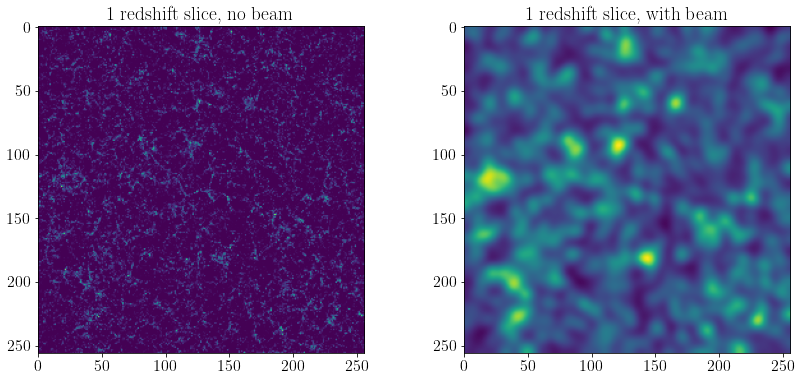

In [5]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(HI_data[:,:,0])
plt.title("1 redshift slice, no beam")
plt.subplot(122)
plt.imshow(HI_noise_smoothed[:,:,0])
plt.title("1 redshift slice, with beam")

Now we run PCA foreground cleaning in order to compare these results to GPR:

In [6]:
pca_res_6 = fg.PCAclean(FGwpol_HI_noise_smoothed, N_FG=6)[0]
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_smoothed, N_FG=7)[0]

## Running GPR

First, define an array with the frequencies of each redshift slice in our data. For our case, the data goes from 1183MHz to 899MHz in 1MHz increments.

In [7]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)

Next, we want to choose which kernels we will use for each component in our data:

In [8]:
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.Poly(1, order=5)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.Poly(1, order=3)*GPy.kern.RatQuad(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

We want to set priors for the kernels, to make sure the foreground kernels aren't fitting to the HI data and the HI kernel isn't fitting to the foregrounds.
Since larger lengthscales mean "smoother" line of sight functions, we want the lengthscale for the foreground kernels to be large and for the HI kernel to be smaller.
We don't do this for the smooth foreground because for that we are using the Polynomial kernel, which doesn't have a lengthscale parameter.

In [9]:
# setting lengthscale prior to be between 0-20MHz for HI data:
kern_21.lengthscale.constrain_bounded(0,20)
# setting lengthscale prior to be between 100-200MHz for polarised foreground data:
# (the "mul" comes from the fact that we are multiplying two kernels together here)
kern_fg.mul.RatQuad.lengthscale.constrain_bounded(100,200)

reconstraining parameters Exponential.lengthscale
reconstraining parameters sum.mul.RatQuad.lengthscale


Parameters for running GPR:

- `Input`: data cube to be cleaned, in $[Nx,Ny,Nz]$ format where $Nz$ is the frequency direction
- `num_restarts`: how many times to optimise the GPR regression model by restarting the GPR fit
- `NprePCA`: set to 0 if no pre-PCA is desired, otherwise this number is the $N_\text{FG}$ number of components used in a pre-PCA clean of the data
- `noise_data`: input here your noise map in $[Nx,Ny,Nz]$ if you have a reasonable estimate from your data, otherwise set to None and use GPR to try to fit your noise
- `zero_noise`: if True, the noise in your GPR model will be set to zero and fixed. Otherwise it will try to fit to noise in your data, in either the heteroscedastic or non-heteroscedastic case. Set to zero if you want to fit your noise with a separate kernel instead, otherwise you will fit to noise twice
- `heteroscedastic`: if True, runs Heteroscedastic regression model (where the noise variance changes with frequency) (Note: you cannot have noise=False and heteroscedastic=True at the same time, to set noise to zero set heteroscedastic=False too). If False, the noise variance will be assumed to be constant with frequency.
- `invert`: if True, inverts data in the frequency direction

In [10]:
Input = FGwpol_HI_noise_smoothed
num_restarts=10
NprePCA=0
noise_data=noise_smoothed
zero_noise=False
heteroscedastic=True
invert=True

Prepare the data for running GPR:

In [11]:
# extract axes from the data:
axes = np.shape(Input)
    
# if desired, do a pre-PCA with N_FG=NprePCA removed components
if NprePCA > 0: Input = fg.PCAclean(Input, N_FG=NprePCA)[0]

# converting data format to LoS pixels [Nx,Ny,Nz] -> [Npix,Nz]
Input = load.LoSpixels(Input)
if noise_data is not None: noise_data = load.LoSpixels(noise_data)

# invert frequency axis
if invert==True: 
    Input = Input[::-1]
    if noise_data is not None: noise_data = noise_data[::-1]

Next, we build our GPR model using our frequency rance, input data and kernel. This will look different depending on the choices made for the parameters, e.g. whether the noise is fixed and whether the model is heteroscedastic.

In [12]:
# build your model, input the freq range, the data, and the kernels
kern = kern_fg + kern_21
    
# this heteroscedastic case assumes a Gaussian noise variance that changes with frequency
if heteroscedastic==True: 
    # this case assumes noise is known, sets noise level to your noise_data variances
        # at different frequencies (since heteroscedastic)
    if noise_data is not None:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
        model.het_Gauss.variance.constrain_fixed(noise_data.var(axis=1)[:, None])
        #model.het_Gauss.variance.constrain_bounded(noise_data[0], noise_data[1])
    # this case assumes noise is not known, model will fit a variance at each frequency
    else:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
    # note: if you want the case of *no noise*, there's no need to use heteroscedastic,
        # so set heteroscedastic = False and see below

# this non-heteroscedastic case assumes constant Gaussian noise variance throughout frequency
else: 
    # this case assumes noise is know, sets the noise variance level to the variance
        # from the input noise_data
    if noise_data is not None:
        model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
        model.Gaussian_noise.constrain_fixed(noise_data.var())
    else:
        # this case assumes there is no noise in your data
        if zero_noise == True:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
            model['.*Gaussian_noise'] = 0.0
            model['.*noise'].fix()
        # this case assumes there is noise but it is unknown, fits a constant variance
        else:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)

Now that we have the model, we optimise it and find the best fitting hyperparameters for the kernels:

In [13]:
model.optimize_restarts(num_restarts=num_restarts)

Optimization restart 1/10, f = -46405148.68539531
Optimization restart 2/10, f = -46475520.00321943
Optimization restart 3/10, f = -46475520.13421706
Optimization restart 4/10, f = -46475520.1667867
Optimization restart 5/10, f = -46475520.06072262
Optimization restart 6/10, f = -46475520.15120939
Optimization restart 7/10, f = -46475520.1103169
Optimization restart 8/10, f = -46419777.05397411
Optimization restart 9/10, f = -46475520.126037516
Optimization restart 10/10, f = -46475520.160444


We can print the optimised model to see things such as the objective function (which we want to be as small as possible), and also the best fit hyperparameters for the kernels.

In [14]:
model

gp.,value,constraints,priors
sum.poly.variance,2.881700345427209e-08,+ve,
sum.poly.scale,2.3213750184437413e-50,+ve,
sum.poly.bias,1.2026786592559415e-06,+ve,
sum.mul.poly.variance,1.257086258401544,+ve,
sum.mul.poly.scale,2.068525261019981e-05,+ve,
sum.mul.poly.bias,1.7159680363202354,+ve,
sum.mul.RatQuad.variance,0.6669557052120381,+ve,
sum.mul.RatQuad.lengthscale,147.12745885557968,"100.0,200.0",
sum.mul.RatQuad.power,0.007771488312511842,+ve,
sum.Exponential.variance,0.00125278105402059,+ve,


Now that we have the optimised model, we can use the best fit hyperparamers found for the foreground kernels and use it to "predict" a sample of the foregrounds in our frequency range, and then subtract that prediction from our input data. This is the process of foreground removal with GPR, and should leave us with an estimate for the HI cosmological signal and noise.

In [15]:
# extract optimised foreground kernel:
k_fg_length = len(kern_fg.parts)
k_fg = model.kern.parts[0]
if k_fg_length > 1:
    for i in range(1, k_fg_length):
        k_fg += model.kern.parts[i]

# make prediction of what FGs would look like using this optimised FG kernel:
y_fit_fg, y_cov_fg = model.predict(freqs[:, np.newaxis], full_cov=True, kern=k_fg,
    include_likelihood=False)

# subtract FG fit from data, to obtain HI+noise residuals:
gpr_res = Input - y_fit_fg

# reshape residuals back to [Nx, Ny, Nz]
gpr_res = np.swapaxes(gpr_res,0,1)
gpr_res = np.reshape(gpr_res,(axes[0], axes[1], axes[2]))

Let's try to understand this a bit better. Here, what we did was generate a sample of what the foregrounds look like given the best fitting foreground kernel (expectation value, `y_fit_fg`), and then subtracted this prediction to obtain the residual, which should contain the HI cosmological signal and the noise. We also, while calculating the expectation value, calculated the covariance (`y_cov_fg`), which can be thought of as the "error" on the expectation value, given by the fact that the kernel isn't a perfect fit to our data.

However, as demonstrated in Section 3.3.2 of https://arxiv.org/pdf/2002.07196.pdf, there is a bias correction we must apply to the recovered residual covariance.

Notation:

- $\textbf{d}$ is our observed data, composed of the foregrounds $(\textbf{f}_\text{fg})$, HI signal $(\textbf{f}_\text{21})$ and noise $(\textbf{n})$
- $\xi(\textbf{f}_\text{fg})$ is the foreground expectation value (`y_fit_fg`)
- cov($\textbf{f}_\text{fg}$) is the covariance on the foreground fit (`y_cov_fg`). Note, this is not the frequency covariance of the foreground expected value, it's essentially the error on the expected value due to the kernel being an imperfect fit.
- $\textbf{r}$ is the residual HI and noise signal, obtained after foreground removal: $\textbf{r} = \textbf{d} - \xi(\textbf{f}_\text{fg})$ (equivalent to `gpr_res = Input - y_fit_fg`)

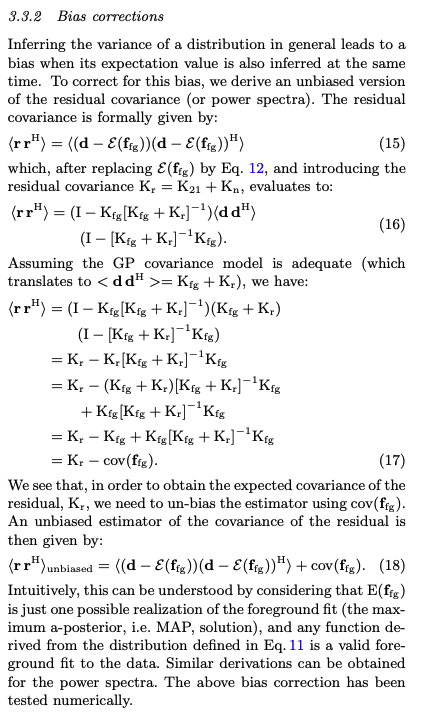

In [16]:
from IPython import display
display.Image("../images/bias_correction.png")

First, let's show that GPR recovers an expected value for the foregrounds which is in line with what we know the foregrounds look like.

In [17]:
# measuring frequency covariance of the GPR foreground expectation value, and of the input data:
C_fit_fg = np.cov(y_fit_fg)
C_input_fg = np.cov(load.LoSpixels(FGwpol_smoothed)[::-1]) #[::-1] just inverts in frequency

Plotting both to show that GPR recovers the foregrounds well:

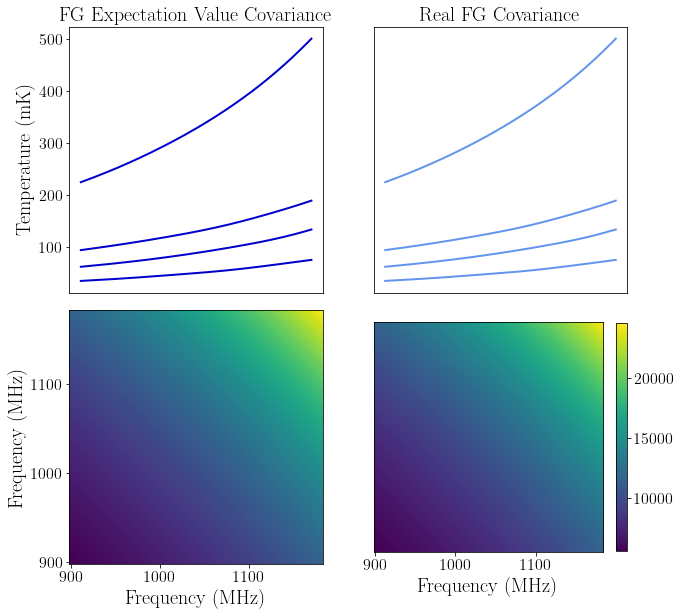

In [18]:
fig = plt.figure(figsize=(10,10))   # open a new plotting window

plt.subplot(221)
plt.plot(freqs,y_fit_fg[:,4444],lw=2, c='mediumblue')
plt.plot(freqs,y_fit_fg[:,444],lw=2, c='mediumblue')
plt.plot(freqs,y_fit_fg[:,44],lw=2, c='mediumblue')
plt.plot(freqs,y_fit_fg[:,4],lw=2, c='mediumblue')
plt.title('FG Expectation Value Covariance', fontsize=20)
plt.ylabel('Temperature (mK)', fontsize=20)
plt.xticks([])

plt.subplot(222)
plt.plot(freqs,load.LoSpixels(FGwpol_smoothed)[::-1][:,4444],lw=2, c='cornflowerblue')
plt.plot(freqs,load.LoSpixels(FGwpol_smoothed)[::-1][:,444],lw=2, c='cornflowerblue')
plt.plot(freqs,load.LoSpixels(FGwpol_smoothed)[::-1][:,44],lw=2, c='cornflowerblue')
plt.plot(freqs,load.LoSpixels(FGwpol_smoothed)[::-1][:,4],lw=2, c='cornflowerblue')
plt.title('Real FG Covariance', fontsize=20)
plt.xticks([])
plt.yticks([])

plt.subplot(223)
pos = plt.imshow(C_fit_fg, interpolation='nearest', origin='lower', cmap='viridis')
plt.xticks([1, 101, 201], [900, 1000, 1100])
plt.yticks([1, 101, 201], [900, 1000, 1100])
plt.xlabel('Frequency (MHz)', fontsize=20)
plt.ylabel('Frequency (MHz)', fontsize=20)

plt.subplot(224)
pos = plt.imshow(C_input_fg, interpolation='nearest', origin='lower', cmap='viridis')
fig.colorbar(pos, fraction=0.045)
plt.xticks([1, 101, 201], [900, 1000, 1100])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplots_adjust(hspace=0.04)

Now we move on to applying the bias correction to the residual covariance.

In [19]:
# calculating residual covariance:
C_fit_res = np.cov(load.LoSpixels(gpr_res, mean_center=False))
# applying bias correction:
C_fit_res_corrected = C_fit_res + y_cov_fg
# calculating the real covariance from the input data:
C_input_21 = np.cov(load.LoSpixels(HI_noise_smoothed)[::-1])

Plotting both for comparison:

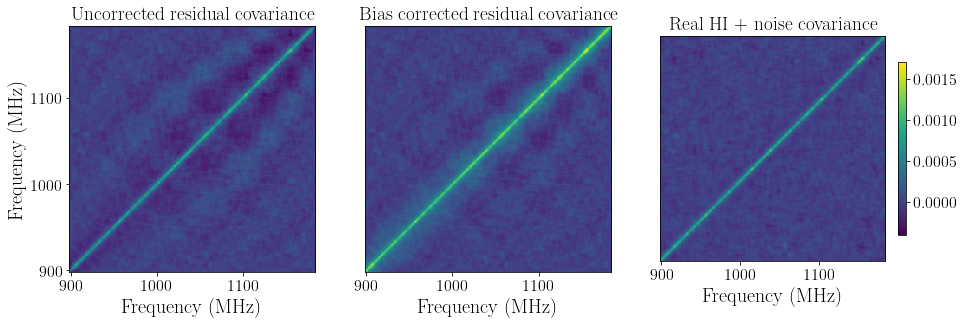

In [20]:
fig = plt.figure(figsize=(15,10))   # open a new plotting window

plt.subplot(131)
pos = plt.imshow(C_fit_res, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.0004, vmax=0.0017)
plt.title('Uncorrected residual covariance')
plt.xticks([1, 101, 201], [900, 1000, 1100])
plt.yticks([1, 101, 201], [900, 1000, 1100])
plt.xlabel('Frequency (MHz)', fontsize=20)
plt.ylabel('Frequency (MHz)', fontsize=20)

plt.subplot(132)
pos = plt.imshow(C_fit_res_corrected, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.0004, vmax=0.0017)
plt.title('Bias corrected residual covariance')
plt.xticks([1, 101, 201], [900, 1000, 1100])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplot(133)
pos = plt.imshow(C_input_21, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.0004, vmax=0.0017)
fig.colorbar(pos, fraction=0.035)
plt.title('Real HI + noise covariance')
plt.xticks([1, 101, 201], [900, 1000, 1100])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplots_adjust(hspace=0.04)

And that's how you run foreground removal with GPR! This can all be done by calling a single function, "GPRclean", from the script "fg_tools." Below shows how this can be done. To summarise the results:

- `gpr_res`: residual map of HI and noise, after GPR foreground subtraction. It should be the same as `gpr_res2`
- `y_cov_fg`: error covariance of the foreground estimate, i.e. how uncertain the estimate of the foreground is, and should be the same as `y_cov_fg2`
- `model`: summary of what the best fit hyperparameters were found for the kernels, andwhat the objective function is, and should be the same as `model2`

In [21]:
gpr_res2, y_cov_fg2, model2 = fg.GPRclean(FGwpol_HI_noise_smoothed, freqs, kern_fg, kern_21, NprePCA=0,
                                         noise_data=noise_smoothed, heteroscedastic=True, zero_noise=False, 
                                         invert=True)

Optimization restart 1/10, f = -46405187.35185401
Optimization restart 2/10, f = -46475520.09046415
Optimization restart 3/10, f = -46475520.0803114
Optimization restart 4/10, f = -46475520.102601975
Optimization restart 5/10, f = -46475520.12029064
Optimization restart 6/10, f = -46475520.1167604
Optimization restart 7/10, f = -46475520.127972975
Optimization restart 8/10, f = -46419706.07890124
Optimization restart 9/10, f = -46475520.1081122
Optimization restart 10/10, f = -46405229.30551039


If you want, you can print the model again to make sure it's similar to the first model. We plot the power spectra of both `gpr_res` and `gpr_res2` below to show that they are consistent.

## Plot power spectrum

In [22]:
# Dimension of data cube:
nx,ny,nz = 256, 256, 285
# Measure the auto-power spectrum, with noise:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
dk = 2*kmin
nkbin = int((kmax-kmin)/dk)
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
# weighting and window function:
w = W = np.ones((nx,ny,nz))

Calculate power spectra:

In [23]:
pk_HI = pk.getpk(HI_noise_smoothed,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_GPR = pk.getpk(gpr_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_GPR2 = pk.getpk(gpr_res2,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] # double checking we get the same result
pk_PCA7 = pk.getpk(pca_res_7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Plot power spectra:

Text(0.5, 0, '$k$ [$h$/Mpc]')

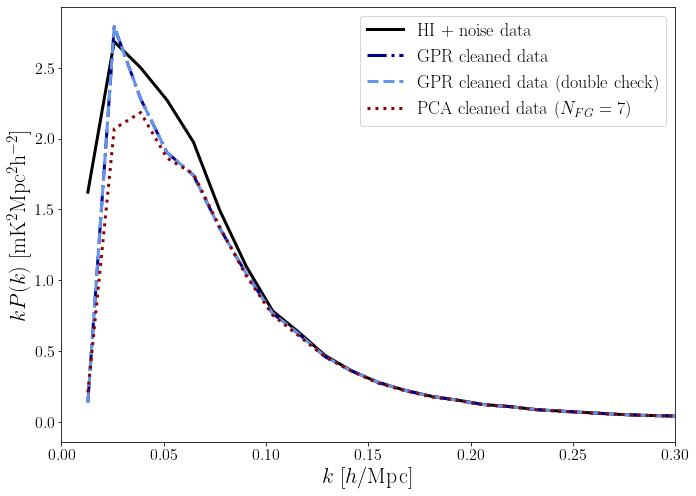

In [24]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*pk_HI),ls='solid', lw=3, c='k', label = r'HI + noise data')
plt.plot(k, (k*pk_GPR),ls='dashdot', lw=3, c='darkblue', label = r'GPR cleaned data')
plt.plot(k, (k*pk_GPR2),ls='dashed', lw=3, c='cornflowerblue', label = r'GPR cleaned data (double check)')
plt.plot(k, (k*pk_PCA7),ls='dotted', lw=3, c='darkred', label = r'PCA cleaned data ($N_{FG}=7$)')

plt.legend(fontsize=18)
plt.xlim(0,0.3)
plt.ylabel('$kP(k)$ [mK$^2$Mpc$^2$h$^{-2}$]', fontsize=22)
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)